# Synthetic Data Generation for "In-Context Learning of Intuitive Physics in Vision Transformers"

In [ ]:
!pip install pymunk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00


In [ ]:
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import pymunk
import math

In [ ]:
# Define constants
IMAGE_HEIGHT = 16
IMAGE_WIDTH = 16
SHAPE_SIDE_LENGTH = 2
FPS = 60

### Generating Sequences of Images

In [ ]:
def simulate_motion(initial_pos, velocity, gravity, restitution, time_step):
    """
    Simulates the motion of a square object within a bounded space using Pymunk physics engine.
    The function creates a 2D physics simulation, adds a square body with specified initial properties,
    and simulates its motion for a given time step.

    Args:
        initial_pos (tuple of float): The initial position (x, y) of the square.
        velocity (tuple of float): The initial velocity (vx, vy) of the square.
        gravity (float): The gravitational acceleration applied in the simulation.
                          Positive values pull the square downward.
        restitution (float): The elasticity coefficient of the square and boundaries.
                              Values are between 0 (perfectly inelastic) and 1 (perfectly elastic).
        time_step (float): The duration for which the simulation is advanced.

    Returns:
        tuple: A tuple containing the new position (x, y) and velocity (vx, vy) of the square after the simulation step.
    """
    # Create a new space and set gravity
    space = pymunk.Space()
    space.gravity = (0, -gravity)

    # Create a body and shape for the square
    body = pymunk.Body(
        1, pymunk.moment_for_box(1, (SHAPE_SIDE_LENGTH, SHAPE_SIDE_LENGTH))
    )
    body.position = pymunk.Vec2d(*initial_pos)  # Unpack the initial_pos tuple
    body.velocity = pymunk.Vec2d(*velocity)  # Unpack the velocity tuple
    shape = pymunk.Poly.create_box(body, (SHAPE_SIDE_LENGTH, SHAPE_SIDE_LENGTH))
    shape.elasticity = restitution
    space.add(body, shape)

    # Add static lines to form boundaries of the space
    static_lines = [
        pymunk.Segment(space.static_body, (0, 0), (0, IMAGE_HEIGHT), 1),  # Left
        pymunk.Segment(
            space.static_body, (0, IMAGE_HEIGHT), (IMAGE_WIDTH, IMAGE_HEIGHT), 1
        ),  # Bottom
        pymunk.Segment(
            space.static_body, (IMAGE_WIDTH, IMAGE_HEIGHT), (IMAGE_WIDTH, 0), 1
        ),  # Right
        pymunk.Segment(space.static_body, (IMAGE_WIDTH, 0), (0, 0), 1),  # Top
    ]
    for line in static_lines:
        line.elasticity = restitution  # Set restitution for the boundaries
        space.add(line)

    # Simulate for the given time step
    space.step(time_step)

    # Return the new position and velocity
    new_pos = body.position.x, body.position.y
    new_vel = body.velocity.x, body.velocity.y

    return new_pos, new_vel


def draw_frame(position):
    """
    Draw a frame with the shape at the given position in black and white.
    """
    image = Image.new(
        "1", (IMAGE_WIDTH, IMAGE_HEIGHT), "white"
    )  # '1' for 1-bit pixels, black and white
    draw = ImageDraw.Draw(image)

    # Draw the square shape in black|
    x, y = position

    draw.rectangle([x, y, x + SHAPE_SIDE_LENGTH, y + SHAPE_SIDE_LENGTH], fill="black")

    return image


def generate_sequence(
    sequence_length,
    initial_speed,
    initial_direction,
    initial_position,
    gravity,
    coefficient_of_restitution,
    frame_rate=30,
):
    """
    Generate a sequence of images of a square object moving in a bounded space.
    """
    images = []
    position = initial_position
    velocity = (
        initial_speed * np.cos(initial_direction),
        -initial_speed * np.sin(initial_direction),
    )

    for frame in range(sequence_length):
        for _ in range(
            frame_rate
        ):  # Advance the simulation frame_rate times before generating an image
            position, velocity = simulate_motion(
                position,
                velocity,
                gravity,
                coefficient_of_restitution,
                1.0 / 60,  # Assuming 60 FPS for the simulation
            )

        adjusted_position = (
            position[0],
            IMAGE_HEIGHT - position[1] - SHAPE_SIDE_LENGTH,
        )
        image = draw_frame(adjusted_position)
        images.append(image)

    return images


def generate_random_sequence(
    sequence_length,
    frame_rate,
    speed_mean,
    speed_sd,
    direction_min,
    direction_max,
    position_x_mean,
    position_x_sd,
    position_y_mean,
    position_y_sd,
    gravity_mean,
    gravity_sd,
    restitution_min,
    restitution_max,
):
    """
    Generate a sequence of images of a square object moving in a bounded space with random initial properties.
    """
    # Sample each parameter
    initial_speed = np.random.normal(speed_mean, speed_sd)
    initial_direction = np.random.uniform(direction_min, direction_max)
    initial_position_x = np.random.normal(position_x_mean, position_x_sd)
    initial_position_y = np.random.normal(position_y_mean, position_y_sd)
    gravity = np.random.normal(gravity_mean, gravity_sd)
    coefficient_of_restitution = np.random.uniform(restitution_min, restitution_max)

    # Generate the sequence
    sequence = generate_sequence(
        sequence_length,
        initial_speed,
        initial_direction,
        (initial_position_x, initial_position_y),
        gravity,
        coefficient_of_restitution,
        frame_rate,
    )

    return sequence

### Displaying Image Sequences

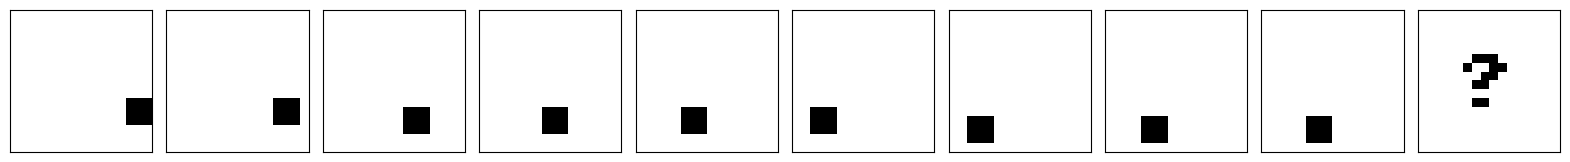

In [ ]:
def display_sequence(sequence):
    # Display the images side by side with boundaries between frames
    fig, axes = plt.subplots(
        1, len(sequence), figsize=(20, 2)
    )  # Adjust figsize as needed

    # Adding a small space between images for clear separation
    plt.subplots_adjust(wspace=0.1)  # Adjust space as needed

    for ax, img in zip(axes, sequence):
        ax.imshow(img)
        ax.axis("on")  # Turn on axis to create a boundary
        ax.set_xticks([])
        ax.set_yticks([])  # Remove tick marks

    plt.show()


def create_question_mark_image(image_width, image_height, font_size):
    # Create a new image with white background
    image = Image.new("1", (image_width, image_height), "white")

    # Prepare to draw on the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    # Calculate the position for the question mark to be centered
    text = "?"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    x = (image_width - text_width) / 2
    y = (image_height - text_height) / 2

    # Draw the question mark on the image
    draw.text((x, y), text, fill="black", font=font)

    return image


# Generate the sequence with the specified parameters
sequence = generate_sequence(
    sequence_length=9,  # Number of frames
    initial_speed=10,
    initial_direction=np.pi / 4,  # 45 degrees in radians
    initial_position=(
        10,
        IMAGE_HEIGHT - 10 - SHAPE_SIDE_LENGTH,
    ),  # Adjusted for Pymunk's coordinate system
    gravity=9.81,
    coefficient_of_restitution=0.8,
)

sequence.append(create_question_mark_image(IMAGE_WIDTH, IMAGE_HEIGHT, 40))

# Display the sequence
display_sequence(sequence)